# Second part

## Preparations

Loading the modules and setting some stuff up:

In [150]:
import typing as tp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from abc import ABC, abstractmethod

from sklearn.metrics import accuracy_score
from pandas.core.series import Series

train_data_path = "data/train_data.csv"
train_target_path = "data/train_target.csv"
test_data_path = "data/test_data.csv"
prediction_path = "data/prediction.csv"

# Unifying the column name for the class label
label_key = "label"

# Setting global seed, which works also for pandas
seed = 42
np.random.seed(seed)

Loading the data and having a first look:

In [151]:
train_df = pd.read_csv(train_data_path, header=None)
train_df.head()

,0,1,2
0,0.94610,9.03653,0.21551
1,0.48205,6.81796,1.06478
2,-0.85521,5.06966,-4.90234
3,-0.61783,6.98347,-0.92534
4,-0.27716,7.49555,-0.34889


In [152]:
target_df = pd.read_csv(train_target_path, header=None, names=[label_key])
target_df.head()

,label
0,leonard
1,sheldon
2,howard
3,leonard
4,leonard


In [153]:
test_df = pd.read_csv(test_data_path, header=None)
test_df.head()

,0,1,2
0,-1.24749,4.16404,-2.00598
1,-0.21120,7.85571,-1.56183
2,-0.48931,6.79337,-3.38007
3,-1.15879,2.61901,-7.11094
4,-0.47080,9.23119,-1.12643


Normalizing the data:

In [154]:
train_df = (train_df - train_df.mean()) / train_df.std()
test_df = (test_df - test_df.mean()) / test_df.std()
train_df.head()

,0,1,2
0,2.023184,0.722199,0.346746
1,1.536448,-0.006684,0.547956
2,0.133814,-0.581066,-0.865776
3,0.382799,0.047692,0.076456
4,0.740123,0.215929,0.213029


Assigning classes names to numbers for simplification:

In [155]:
classes = sorted(target_df[label_key].unique().tolist())
target_df[label_key] = target_df[label_key].apply(lambda x: classes.index(x))
target_df.head()

,label
0,1
1,3
2,0
3,1
4,1


Having a look at the scatter plot:

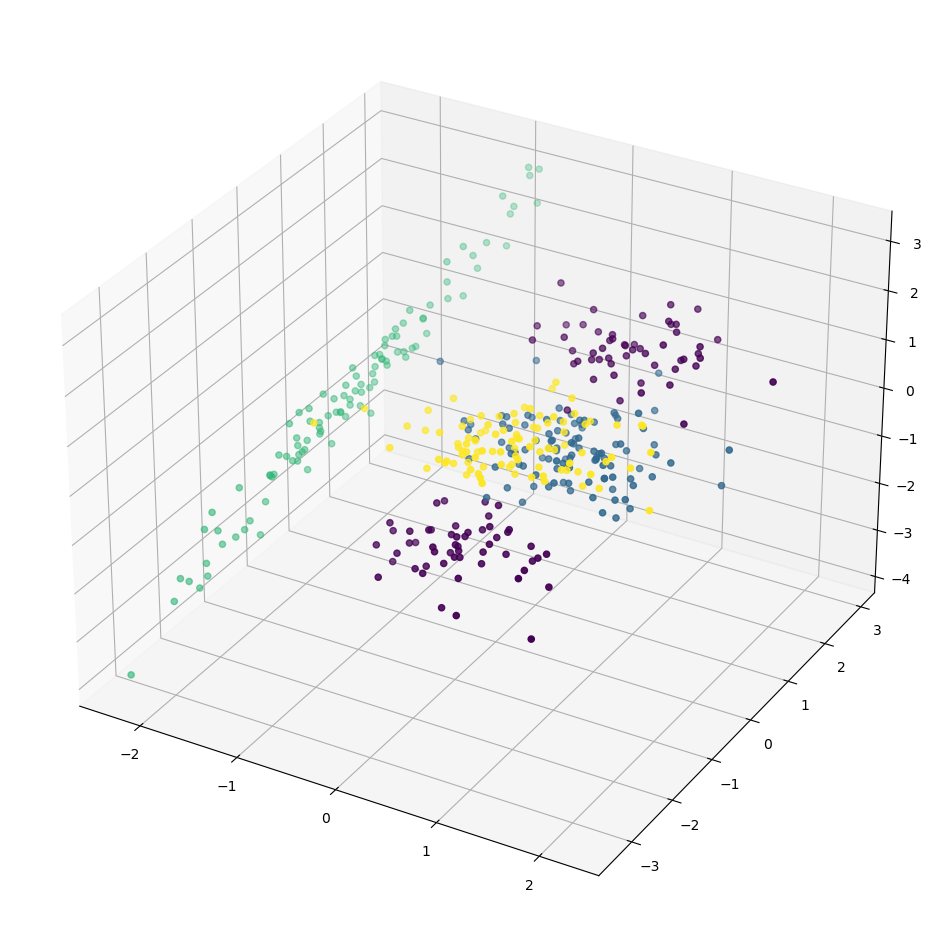

In [156]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection="3d")

ax.scatter(*train_df.values.T, c=target_df.values)
plt.show()

## Cross-Validation

Declaring Model abstraction:

In [157]:
class Model(ABC):

    @abstractmethod
    def fit(self, dataset: pd.DataFrame, labels: pd.DataFrame) -> None:
        pass

    @abstractmethod
    def predict(self, dataset: pd.DataFrame) -> pd.DataFrame:
        pass

Implementing cross-validation class:

In [158]:
class KFolds:
    def __init__(self, k: int, dataset: pd.DataFrame, labels: pd.DataFrame, model: Model):
        self._df = dataset.copy().join(labels)
        self._k = k
        self._model = model

        self._scores = []
        self._folds = []

        self.split()

    @property
    def scores(self) -> tp.List[float]:
        return self._scores

    @property
    def mean_score(self) -> float:
        return float(np.mean(self._scores))

    def split(self) -> None:
        # Shuffling the data
        self._folds = np.array_split(
            self._df.sample(frac=1, random_state=seed).reset_index(drop=True),
            self._k,
        )

    def validate(self) -> None:
        # Nullifying the scores to have them recalculated correctly
        self._scores = []

        for i, fold in enumerate(self._folds):
            # Current fold is a validation set
            validation_labels = fold[label_key]
            unlabeled_validation_df = fold.drop(label_key, axis=1)

            # Other folds are joined to create a train dataset
            other_splits = [f for j, f in enumerate(self._folds) if j != i]
            df_train = pd.concat(other_splits)

            self._model.fit(
                dataset=df_train.drop([label_key], axis=1),
                labels=pd.DataFrame(df_train[label_key])
            )
            result_labels = self._model.predict(unlabeled_validation_df)

            self._scores.append(accuracy_score(validation_labels, result_labels))


Implementing SNPC:

In [159]:
class SNPC(Model):
    def __init__(
            self,
            variance_init: float,
            variance_final: float,
            betta_init: float,
            gamma: float,
            learning_rate: tp.Callable[[int], float],
            prototype_count: int,
    ):
        if not variance_init or not variance_final:
            raise ValueError("Variance shouldn't be zero")

        if not (0.7 < betta_init < 1):
            raise ValueError("Betta should be less than 1 and significantly greater than zero")

        if gamma <= 1:
            raise ValueError("Gamma should be greater than one")

        self._var_init = variance_init
        self._var_final = variance_final
        self._betta_init = betta_init
        self._gamma = gamma
        self._lr = learning_rate
        self._p_cnt = prototype_count

        self._centroid_factor = 0.02
        self._epoch_factor = 10
        self._nu = 0.1

        self._dataset = None
        self._labels = None

        # Prototypes and their labels
        self._p = None
        self._p_labels = None

    @property
    def prototypes(self) -> pd.DataFrame:
        return self._p

    @property
    def prototype_labels(self) -> pd.DataFrame:
        return self._p_labels

    @staticmethod
    def _distance(a: Series, b: Series, variance: float) -> float:
        d = np.linalg.norm(a.values - b.values) ** 2 / (2 * variance)
        return np.exp(-d)

    def _generate_prototypes(self) -> None:
        label_cnt = self._labels.groupby([label_key]).size()
        if self._p_cnt < len(label_cnt):
            raise ValueError(
                "Cannot fit this dataset. "
                "The amount of prototypes should be greater or equal to the number of classes"
            )

        # Defining the number of prototypes of each class
        # Min one for each
        # Ratio is the same as in training dataset
        label_cnt = label_cnt / len(self._labels) * self._p_cnt
        label_cnt = pd.DataFrame(label_cnt, columns=["approx_cnt"])
        label_cnt["p_cnt"] = 1

        for _ in range(self._p_cnt - len(label_cnt)):
            label_to_inc = label_cnt["approx_cnt"].argmax()
            label_cnt.loc[label_to_inc, "p_cnt"] += 1
            label_cnt.loc[label_to_inc, "approx_cnt"] -= 1

        # For each class, calculate prototypes by adding random vectors to its centroid
        prototypes = []
        p_labels = []

        for label, row in label_cnt.iterrows():
            df = self._dataset.join(self._labels)
            df = df.loc[df[label_key] == label].drop(label_key, axis=1)

            centroid = df.sum() / len(df)
            std_vector = df.std()

            for _ in np.arange(row['p_cnt']):
                rand_factor = np.random.uniform(-1, 1)
                prototype = centroid + std_vector * self._centroid_factor * row['p_cnt'] * rand_factor

                prototypes.append(prototype.to_dict())
                p_labels.append({label_key: label})

        self._p = pd.DataFrame([{str(k): v for k, v in prototype.items()} for prototype in prototypes])
        self._p_labels = pd.DataFrame(p_labels)

    def _calculate_probabilities(self, datapoint: Series, variance: float) -> None:
        if self._p is None:
            raise AttributeError("No prototypes generated. Use ._generate_prototypes() first.")

        self._p["distance"] = self._p.apply(
            lambda row: SNPC._distance(row, datapoint, variance=variance),
            axis=1,
        )

        distance_sum = self._p["distance"].sum()

        self._p["probability"] = self._p["distance"].apply(lambda d: d / distance_sum)

        self._clear_prototypes(["distance"])


    def _update_prototypes(self, datapoint: Series, datapoint_label: int, alpha: float, variance: float) -> None:
        if "probability" not in self._p.columns:
            raise AttributeError(
                "No calculated probabilities found in prototypes. "
                "Use ._calculate_probabilities() first."
            )

        self._p = self._p.join(self._p_labels)
        ls = self._p.loc[self._p[label_key] == datapoint_label]["probability"].sum()

        if ls * (1 - ls) < self._nu:
            # In that case we don't make an update
            self._clear_prototypes()
            return

        self._p["delta_factor"] = self._p[label_key].apply(
            lambda l: -1 * ls if l == datapoint_label else (1 - ls)

        )
        self._p["delta_factor"] = self._p.apply(
            lambda row: row["delta_factor"] * row["probability"] * alpha / variance,
            axis=1,
        )

        delta_factors = self._p["delta_factor"]

        self._clear_prototypes()

        new_prototypes = []
        for idx, row in self._p.iterrows():
            prototype = row.values - (datapoint.iloc[0] - row.values) * delta_factors.loc[idx]
            prototype.name = idx
            new_prototypes.append(prototype)

        self._p = pd.concat(new_prototypes, axis=1).transpose()


    def _clear_prototypes(self, columns: tp.List | None = None) -> None:
        # Removes in-between calc columns
        columns = ["distance", "probability", "delta_factor", label_key] if columns is None else columns
        self._p.drop(columns, axis=1, errors="ignore", inplace=True)

    def fit(self, dataset: pd.DataFrame, labels: pd.DataFrame) -> None:
        self._dataset = dataset
        self._labels = labels

        self._generate_prototypes()

        var = self._var_init
        betta = self._betta_init
        while var > self._var_final:
            alpha = self._lr(0)
            for t in range(len(self._dataset) * self._epoch_factor):
                # Selecting a datapoint
                datapoint = dataset.sample(n=1)
                datapoint_label = labels.loc[datapoint.index[0]][label_key]

                self._calculate_probabilities(datapoint, var)
                self._update_prototypes(datapoint, datapoint_label, alpha, var)

                alpha = self._lr(t + 1)

            var *= betta
            betta **= self._gamma

    def predict(self, dataset: pd.DataFrame) -> pd.DataFrame:
        if self._p is None:
            raise AttributeError("No training has been completed. Use .fit() first.")

        # Preserving indexing
        res = dataset.copy()
        res[label_key] = 0
        res = res.filter([label_key])

        for idx, datapoint in dataset.iterrows():
            # Calculate assignment probabilities for all prototypes
            self._calculate_probabilities(datapoint, variance=self._var_final)

            labels = self._p.join(self._p_labels).groupby(label_key).sum(["probability"])
            res.loc[idx][label_key] = labels["probability"].idxmax()

            self._clear_prototypes()

        return res


## Optimizing hyperparameter

In [160]:
scores = []

min_prototype_cnt = 4
max_prototype_cnt = 32

prototype_counts = list(range(min_prototype_cnt, max_prototype_cnt + 1))
for prototype_cnt in prototype_counts:
    snpc = SNPC(
        variance_init=1,
        variance_final=0.05,
        betta_init=0.8,
        gamma=2,
        learning_rate=lambda t: 0.1 * (100/(100 + t)),
        prototype_count=prototype_cnt
    )
    kfolds = KFolds(k=5, dataset=train_df, labels=target_df, model=snpc)
    kfolds.validate()
    scores.append(kfolds.mean_score)


The best score is 0.9145137006925624, by using 16 prototypes


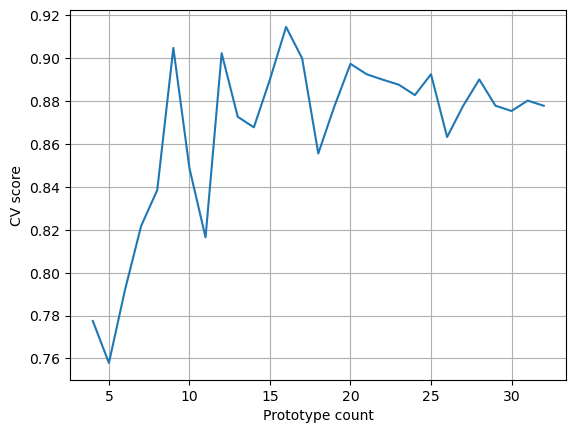

In [161]:
best_prototype_cnt = np.argmax(scores) + min_prototype_cnt
print(f"The best score is {max(scores)}, by using {best_prototype_cnt} prototypes")

fig, ax = plt.subplots()
ax.plot(prototype_counts, scores)

ax.set(xlabel="Prototype count", ylabel="CV score")
ax.grid()

plt.show()


Training the model on the whole dataset:


In [162]:
snpc = SNPC(
    variance_init=1,
    variance_final=0.05,
    betta_init=0.8,
    gamma=2,
    learning_rate=lambda t: 0.1 * (100/(100 + t)),
    prototype_count=best_prototype_cnt,
)
snpc.fit(train_df, target_df)

Using trained model to predict the labels:

In [163]:
result = snpc.predict(test_df)
result

,label
0,3
1,1
2,1
3,0
4,1
...,...
98,3
99,1
100,0
101,3


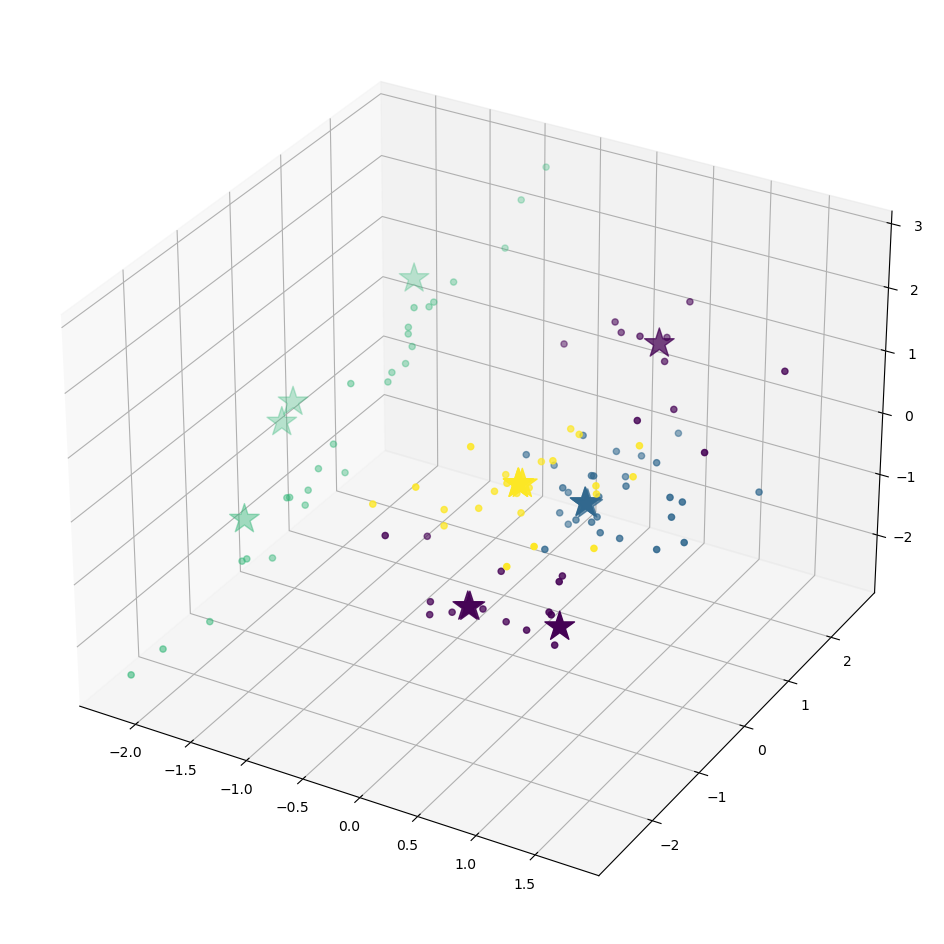

In [164]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection="3d")

ax.scatter(*test_df.values.T, c=result.values)
ax.scatter(*snpc.prototypes.values.T, c=snpc.prototype_labels, s=500, marker="*")

plt.show()

Converting the labels back to the original:

In [165]:
result[label_key] = result[label_key].apply(lambda x: classes[x])
result

,label
0,sheldon
1,leonard
2,leonard
3,howard
4,leonard
...,...
98,sheldon
99,leonard
100,howard
101,sheldon


Loading the result:

In [166]:
result[label_key].to_csv(prediction_path, header=False, index=False)